# Wstęp
Zadanie 12 jest trzecią częścią do zajęć laboratoryjnych poświęconych sieciom rekurencyjnym i predykcji z wykorzystaniem danych multimodalnych. Efektem prac będzie sieć rekurencyjna do predykcji kursu kryptowaluty Bitcoin (BTC) w oparciu o dane z giełdy oraz o wyniki analizy emocji komunikatów z mediów społecznościowych, do których również należy utworzyć dedykowany model sieci rekurencyjnej. Plan realizacji etapów wygląda następująco:

1.   EmoTweet - model sieci rekurencyjnej do analizy emocji (10 pkt., laboratorium 10)
2. Agregacja informacji emotywnej i przygotowanie MultiBTC - multimodalnego model sieci rekurencyjnej do predykcji kursu BTC (10 pkt., laboratorium 11)
3. Ewaluacja modelu MultiBTC (10 pkt., laboratorium 12)

Łącznie można otrzymać 30 punktów.

# Cel ćwiczenia

Celem trzeciego etapu prac jest ewaluacja modelu MultiBTC sieci rekurencyjnej LSTM do przewidywania kolejnego elementu sekwencji pod warunkiem wcześniejszych obserwacji. 

# Warunki zaliczenia

Do zaliczenia trzeciego etapu należy wytrenować modelu oraz wykonać ewaluację predykcji dla scenariusza godzinnego oraz dziennego, z uwzględnieniem wpływu:
 * wybranych hiperparametrów 
 * dodatkowych kroków wstępnego przetwarzania danych
 * wymiarów afektywnych


# Realizacja zadania

Szczegółowa realizacja zadania powinna uwzględniać następujące elementy ewaluacji:

### Hiperparametry (4 pkt.)

W zadaniu tym istnieje szereg ustawień hiperparametrów, które mogą mieć istotny wpływ na jakość predykcji. Należy wybrać jeden z nich i zbadać jego wpływ dla 3 wybranych wartości. 

1. Długość sekwencji w modelu LSTM.
2. Liczba jednostek w warstwie ukrytej. 
3. Optymalizator i jego parametry (np. `learning rate`).
4. Użycie dodatkowej warstwy Dropout (parametr: `probability`) przed warstwą z wynikiem predykcji.

### Przetwarzanie wstępne (3 pkt.)

Jednocześnie istotny wpływ mogą mieć dodatkowe elementy przetwarzania wstępnego danych. Należy wybrać jeden z nich i porównać z wariantem bez przetwarzania:
1. Normalizacja wartości (sprowadzenie konkretnych kwot do wartości z zakresu 0-1).
2. Zamiana wartości liczbowej na procentową zmianę względem poprzedniego kursu.

### Wymiary afektywne  (3 pkt.)

Ostatnim aspektem jest zbadanie wpływu wymiarów afektywnych. Dla najlepszej otrzymanej konfiguracji należy porównać wyniki z modelem, który wykorzystuje wyłącznie dane z giełdy.

### Ogólne uwagi końcowe

Wszystkie wyniki proszę podać z wykorzystaniem 2 miar jakości predykcji:
1. [Mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error)
2. [R2-score](https://en.wikipedia.org/wiki/Coefficient_of_determination)

Przy każdej procedurze uczenia należy wykorzystywać zbiór walidacyjny w taki sposób, by po każdej epoce uczenia sprawdzać jakość predykcji na tym zbiorze. Należy zapamiętać ten model, którego jakość była najlepsza na zbiorze walidacyjnym i na tym modelu dopiero robić ostateczną ewaluację z wykorzystaniem zbioru testowego. Proszę obserwować proces uczenia. Spadek jakości na zbiorze walidacyjnym w dalszych epokach uczenia (po wcześniejszym wzrastaniu w poprzednich epokach) może oznaczać, że model przeuczył się na zbiorze uczącym i można przerwać trenowanie. Często definiuje się w tym celu dodatkowy parametr tzw. **cierpliwości** (ang. patience), który określa, przez ile epok możemy kontynuować uczenie bez otrzymania wyniki lepszego niż dotychczasowy najlepszy.


In [42]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

df_1h = pd.read_csv('df_1h.csv')
df_24h = pd.read_csv('df_24h.csv')

# Mod model

In [43]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length, -1] 
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

def fit(model, criterion, optimizer, num_epochs, train_loader, val_loader, patience = 20):
  train_losses = []
  val_losses = []
  train_r2 = []
  val_r2 = []
  best_loss = np.inf
  counter = 0
  for epoch in tqdm(range(num_epochs)):
      true_values = []
      train_predictions = []
      val_predictions = []


      model.train()
      train_loss = 0.0
      for inputs, targets in train_loader:
          inputs, targets = inputs, targets
          
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, targets.unsqueeze(1))
          loss.backward()
          optimizer.step()
          train_predictions.extend(outputs.detach().numpy())
          true_values.extend(targets.detach().numpy())
          
          train_loss += loss.item()

      train_r2.append(r2_score(true_values, train_predictions))

      model.eval()
      val_loss = 0.0
      with torch.no_grad():
          for inputs, targets in val_loader:
              inputs, targets = inputs, targets
              outputs = model(inputs)
              loss = criterion(outputs, targets.unsqueeze(1))

              val_predictions.extend(outputs.detach().numpy())
              true_values.extend(targets.detach().numpy())

              val_loss += loss.item()
          early_loss = val_loss/len(val_loader)
          val_r2.append(r2_score(true_values[len(train_predictions):], val_predictions))
      train_losses.append(train_loss/len(train_loader)) 
      val_losses.append(val_loss/len(val_loader))
      if early_loss < best_loss:
        best_loss = early_loss
        counter = 0
      else:
        counter += 1
        if counter > patience:
          break


  n = len(train_losses)
  xs = np.arange(1, 1+n)

  return best_loss, xs, train_losses, val_losses, train_r2, val_r2

def MultiBTC(seq_length = 10, target_name = 'close', df = df_24h, num_epochs = 10, hidden_dim = 64, learning_rate = .001, scaler = MinMaxScaler()):
  df_dates =df.copy()
  df = df.copy()
  df.drop(columns = 'date', inplace=True)
  
  cols = list(df.columns)
  cols.remove(target_name)
  df = df[cols + [target_name]]

  scaled_data = scaler.fit_transform(df)

  sequences, targets = create_sequences(scaled_data, seq_length)

  train_size = int(len(sequences) * 0.8)
  val_size = int(len(sequences) * 0.1)


  train_sequences = sequences[:train_size]
  train_targets = targets[:train_size]
  val_sequences = sequences[train_size:train_size + val_size]
  val_targets = targets[train_size:train_size + val_size]
  test_sequences = sequences[train_size + val_size:]
  test_targets = targets[train_size + val_size:]


  train_dataset = TimeSeriesDataset(train_sequences, train_targets)
  val_dataset = TimeSeriesDataset(val_sequences, val_targets)
  test_dataset = TimeSeriesDataset(test_sequences, test_targets)
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

  input_dim = train_sequences.shape[2]
  num_layers = 2
  output_dim = 1

  model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  return model,  *fit(model, criterion, optimizer, num_epochs, train_loader, val_loader), test_loader, scaler, df, df_dates

def plot_results(model, best_loss, xs, train_losses, val_losses, train_r2, val_r2, test_loader, scaler, df, df_dates, printit=True):
  if printit:

    fig, (ax1,ax2) = plt.subplots(1,2,figsize = (25,10))

    ax1.plot(xs, train_losses,label = 'train loss')
    ax1.plot(xs, val_losses,label = 'val loss')
    ax1.set_title("MSE Error for epoch")
    ax1.legend()

    ax2.plot(xs, train_r2,label = 'train r2')
    ax2.plot(xs, val_r2, label = 'val r2')
    ax2.set_title("R2 Error for epoch")
    ax2.legend()  


  model.eval()
  predictions = []
  true_values = []

  with torch.no_grad():
      for inputs, targets in test_loader:
          inputs, targets = inputs, targets
          outputs = model(inputs)
          predictions.append(outputs.cpu().numpy())
          true_values.append(targets.cpu().numpy())

  predictions = np.concatenate(predictions)
  true_values = np.concatenate(true_values)

  predictions = scaler.inverse_transform(np.concatenate([np.zeros((predictions.shape[0], df.shape[1]-1)), predictions], axis=1))[:, -1]
  true_values = scaler.inverse_transform(np.concatenate([np.zeros((true_values.shape[0], df.shape[1]-1)), true_values.reshape(-1, 1)], axis=1))[:, -1]

  print(f"Best loss: {best_loss}")
  dates = df_dates[len(df_dates) - len(true_values): ]['date']
  return pd.DataFrame({'date': dates, 'True BTC': true_values, 'Predicted BTC': predictions})

def make_model(btc_df, day_model = False):
  if day_model:
    real_df = btc_df[btc_df['date'].dt.time == pd.to_datetime('23:00:00').time()][['date','True BTC']]
    pred_df = btc_df.groupby('date').mean().reset_index()[['date', 'Predicted BTC']]
    btc_df = real_df.merge(pred_df, how = 'left', on = 'date')
  df = btc_df.copy()
  predictions = df['Predicted BTC']
  true_values = df['True BTC']
  n= len(predictions)
  xs = np.arange(n)
  fig, ax = plt.subplots()
  ax.plot(xs, true_values, label = 'real')
  ax.plot(xs, predictions, label = 'predictions')
  ax.legend()
  print(f'RMSE: {np.sqrt(mean_squared_error(true_values, predictions))}')
  display(df)

# Zad 1

In [44]:
params = {"seq_length": [5,10,15],"hidden_dim": [8,16,32,64], "learning_rate": [0.001, 0.01, 0.1]}

## sequence

100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Best loss: 1.600422470287964e-05
RMSE: 103.06127653254136


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8938.023176
19008,2020-03-03 01:00:00,8828.270134,8903.627649
19009,2020-03-03 02:00:00,8879.760086,8870.392431
19010,2020-03-03 03:00:00,8880.010186,8874.012398
19011,2020-03-03 04:00:00,8842.279863,8885.909019
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9430.614605
21115,2020-05-29 20:00:00,9421.340059,9423.262775
21116,2020-05-29 21:00:00,9394.860025,9413.895120
21117,2020-05-29 22:00:00,9427.440141,9406.656857


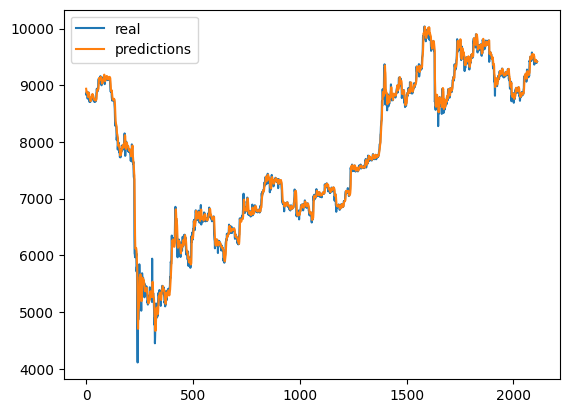

In [55]:
btc_df = plot_results(*MultiBTC(df = df_1h, seq_length=5), printit=False)
make_model(btc_df)

100%|██████████| 10/10 [00:35<00:00,  3.59s/it]

Best loss: 1.557212106655987e-05
RMSE: 103.77749701323673


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8970.270105
19008,2020-03-03 01:00:00,8828.270134,8923.648109
19009,2020-03-03 02:00:00,8879.760086,8908.367425
19010,2020-03-03 03:00:00,8880.010186,8934.557277
19011,2020-03-03 04:00:00,8842.279863,8944.777524
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9486.945793
21115,2020-05-29 20:00:00,9421.340059,9470.607093
21116,2020-05-29 21:00:00,9394.860025,9474.984873
21117,2020-05-29 22:00:00,9427.440141,9463.054015


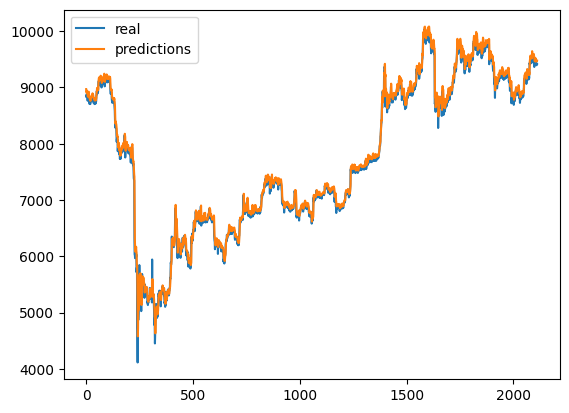

In [46]:
btc_df = plot_results(*MultiBTC(df = df_1h, seq_length=10), printit=False)
make_model(btc_df)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:24<00:00,  2.41s/it]

Best loss: 2.1603340549132334e-05
RMSE: 127.31738147433978


,date,True BTC,Predicted BTC
19006,2020-03-02 23:00:00,8917.340098,8971.047959
19007,2020-03-03 00:00:00,8848.379945,8992.187812
19008,2020-03-03 01:00:00,8828.270134,8963.022238
19009,2020-03-03 02:00:00,8879.760086,8933.862093
19010,2020-03-03 03:00:00,8880.010186,8934.028269
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9474.471314
21115,2020-05-29 20:00:00,9421.340059,9471.860512
21116,2020-05-29 21:00:00,9394.860025,9464.016416
21117,2020-05-29 22:00:00,9427.440141,9458.233655


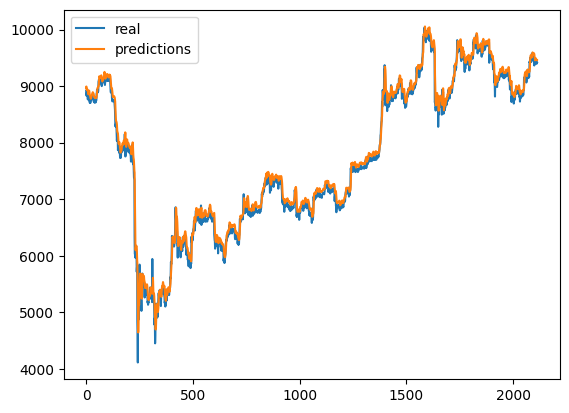

In [47]:
btc_df = plot_results(*MultiBTC(df = df_1h, seq_length=3), printit=False)
make_model(btc_df)

## hidden

100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Best loss: 2.268633006403406e-05
RMSE: 147.34361267957317


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,9016.127189
19008,2020-03-03 01:00:00,8828.270134,8996.889175
19009,2020-03-03 02:00:00,8879.760086,8957.023616
19010,2020-03-03 03:00:00,8880.010186,8957.442814
19011,2020-03-03 04:00:00,8842.279863,8964.410519
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9519.716720
21115,2020-05-29 20:00:00,9421.340059,9506.138714
21116,2020-05-29 21:00:00,9394.860025,9492.498914
21117,2020-05-29 22:00:00,9427.440141,9490.980783


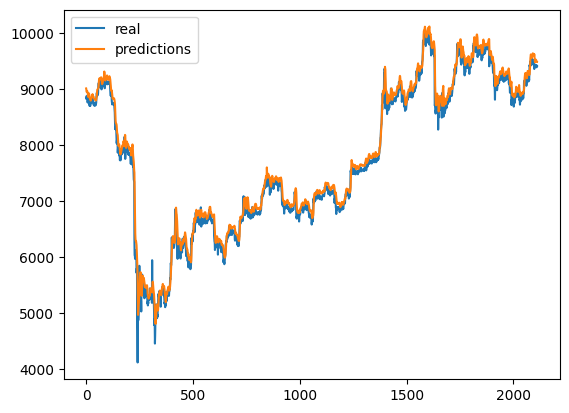

In [48]:
btc_df = plot_results(*MultiBTC(df = df_1h, hidden_dim=8), printit=False)
make_model(btc_df)

100%|██████████| 10/10 [01:13<00:00,  7.31s/it]

Best loss: 2.8745121116199616e-05
RMSE: 144.77865682027382


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,9002.907839
19008,2020-03-03 01:00:00,8828.270134,8993.346452
19009,2020-03-03 02:00:00,8879.760086,8973.420352
19010,2020-03-03 03:00:00,8880.010186,8962.309101
19011,2020-03-03 04:00:00,8842.279863,8949.241314
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9520.783503
21115,2020-05-29 20:00:00,9421.340059,9522.534615
21116,2020-05-29 21:00:00,9394.860025,9514.396997
21117,2020-05-29 22:00:00,9427.440141,9501.722522


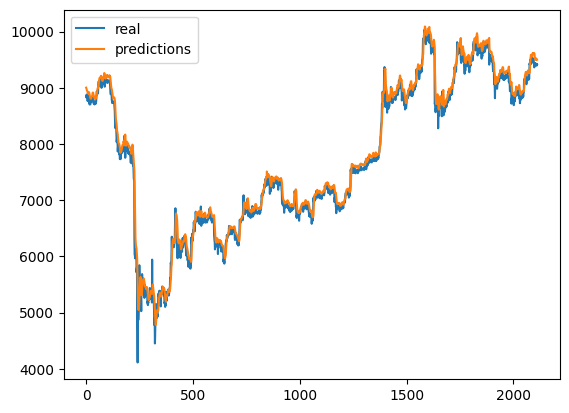

In [49]:
btc_df = plot_results(*MultiBTC(df = df_1h, hidden_dim=16), printit=False)
make_model(btc_df)

100%|██████████| 10/10 [00:33<00:00,  3.35s/it]

Best loss: 1.8512653465415607e-05
RMSE: 124.88867584355768


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,9000.555070
19008,2020-03-03 01:00:00,8828.270134,8966.634272
19009,2020-03-03 02:00:00,8879.760086,8931.030837
19010,2020-03-03 03:00:00,8880.010186,8917.785183
19011,2020-03-03 04:00:00,8842.279863,8927.831738
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9495.961890
21115,2020-05-29 20:00:00,9421.340059,9488.968298
21116,2020-05-29 21:00:00,9394.860025,9479.906274
21117,2020-05-29 22:00:00,9427.440141,9470.693939


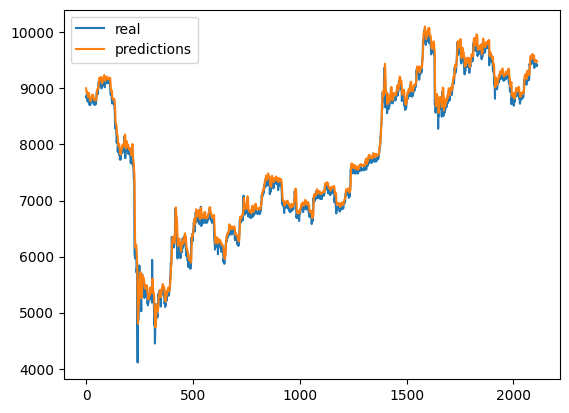

In [50]:
btc_df = plot_results(*MultiBTC(df = df_1h, hidden_dim=32), printit=False)
make_model(btc_df)

100%|██████████| 10/10 [01:00<00:00,  6.08s/it]


Best loss: 1.3264492712082618e-05
RMSE: 92.55496506295336


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8932.459200
19008,2020-03-03 01:00:00,8828.270134,8888.693930
19009,2020-03-03 02:00:00,8879.760086,8836.576433
19010,2020-03-03 03:00:00,8880.010186,8861.940415
19011,2020-03-03 04:00:00,8842.279863,8886.420073
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9438.290020
21115,2020-05-29 20:00:00,9421.340059,9425.394255
21116,2020-05-29 21:00:00,9394.860025,9423.206826
21117,2020-05-29 22:00:00,9427.440141,9415.058353


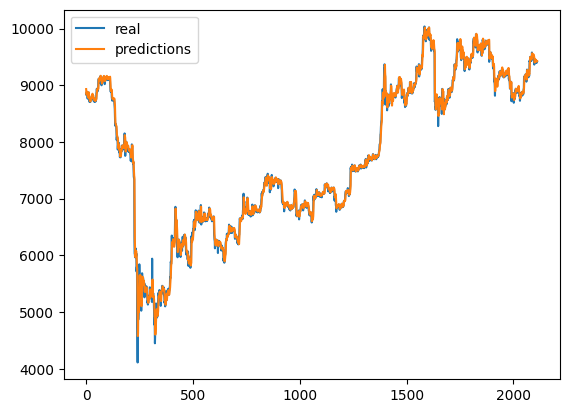

In [51]:
btc_df = plot_results(*MultiBTC(df = df_1h, hidden_dim=64), printit=False)
make_model(btc_df)

## learning rate

100%|██████████| 10/10 [02:20<00:00, 14.03s/it]


Best loss: 0.00035599809157385164
RMSE: 746.6421911883173


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,9543.510797
19008,2020-03-03 01:00:00,8828.270134,9540.315874
19009,2020-03-03 02:00:00,8879.760086,9549.573301
19010,2020-03-03 03:00:00,8880.010186,9564.146694
19011,2020-03-03 04:00:00,8842.279863,9562.778872
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,10100.345985
21115,2020-05-29 20:00:00,9421.340059,10074.679713
21116,2020-05-29 21:00:00,9394.860025,10056.493870
21117,2020-05-29 22:00:00,9427.440141,10080.040770


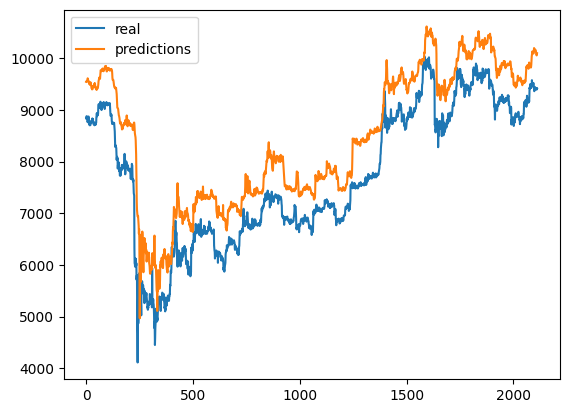

In [52]:
btc_df = plot_results(*MultiBTC(df = df_1h, learning_rate=.1), printit=False)
make_model(btc_df)

100%|██████████| 10/10 [01:31<00:00,  9.19s/it]


Best loss: 1.1928502358800456e-05
RMSE: 93.1265622808561


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8858.003545
19008,2020-03-03 01:00:00,8828.270134,8830.860059
19009,2020-03-03 02:00:00,8879.760086,8783.494864
19010,2020-03-03 03:00:00,8880.010186,8836.939265
19011,2020-03-03 04:00:00,8842.279863,8861.043148
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9379.316716
21115,2020-05-29 20:00:00,9421.340059,9354.859187
21116,2020-05-29 21:00:00,9394.860025,9369.196258
21117,2020-05-29 22:00:00,9427.440141,9359.086239


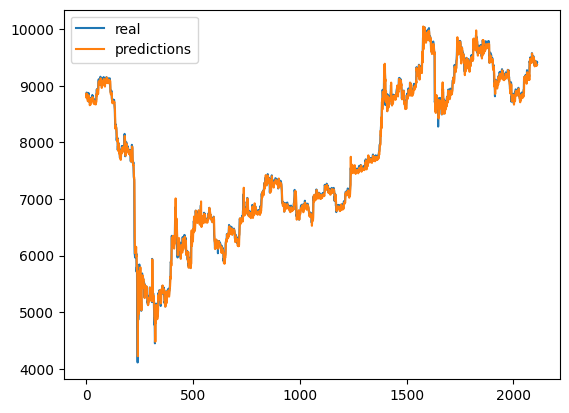

In [53]:
btc_df = plot_results(*MultiBTC(df = df_1h, learning_rate=.01), printit=False)
make_model(btc_df)

100%|██████████| 10/10 [01:32<00:00,  9.21s/it]


Best loss: 1.9326056830819155e-05
RMSE: 103.62663248396439


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8858.565955
19008,2020-03-03 01:00:00,8828.270134,8816.852835
19009,2020-03-03 02:00:00,8879.760086,8797.623589
19010,2020-03-03 03:00:00,8880.010186,8788.850494
19011,2020-03-03 04:00:00,8842.279863,8815.897113
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9357.746392
21115,2020-05-29 20:00:00,9421.340059,9345.420134
21116,2020-05-29 21:00:00,9394.860025,9340.666162
21117,2020-05-29 22:00:00,9427.440141,9335.630359


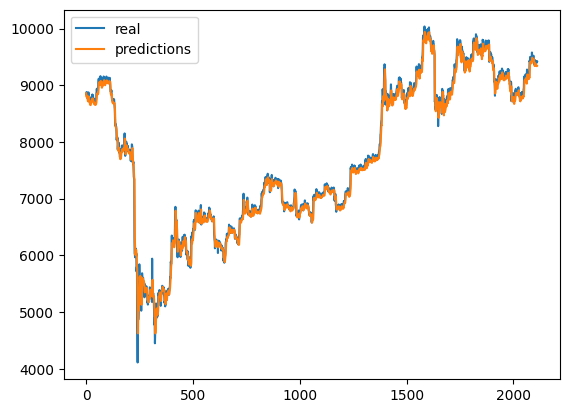

In [54]:
btc_df = plot_results(*MultiBTC(df = df_1h, learning_rate=.001), printit=False)
make_model(btc_df)

# Zad 2

100%|██████████| 10/10 [00:37<00:00,  3.76s/it]

Best loss: 1.4413978357714024e-05
RMSE: 97.92021077965443


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8939.378889
19008,2020-03-03 01:00:00,8828.270134,8896.152230
19009,2020-03-03 02:00:00,8879.760086,8852.967324
19010,2020-03-03 03:00:00,8880.010186,8857.015674
19011,2020-03-03 04:00:00,8842.279863,8884.329094
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9439.840301
21115,2020-05-29 20:00:00,9421.340059,9426.077748
21116,2020-05-29 21:00:00,9394.860025,9421.799757
21117,2020-05-29 22:00:00,9427.440141,9416.868336


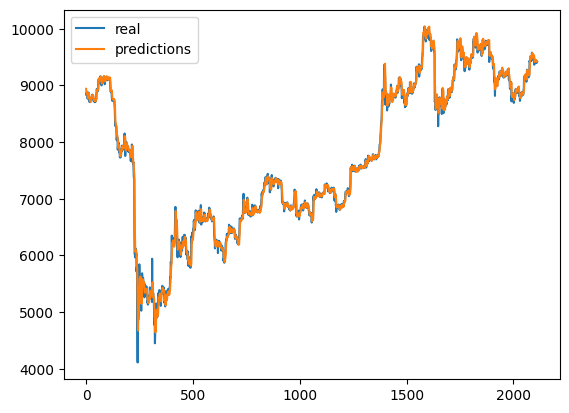

In [56]:
btc_df = plot_results(*MultiBTC(df = df_1h, scaler = MinMaxScaler()), printit=False)
make_model(btc_df)

100%|██████████| 10/10 [00:47<00:00,  4.78s/it]

Best loss: 0.0005109357783415666
RMSE: 99.38687410503859


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.380045,8872.797138
19008,2020-03-03 01:00:00,8828.269942,8819.242702
19009,2020-03-03 02:00:00,8879.759936,8892.862288
19010,2020-03-03 03:00:00,8880.010025,8815.673601
19011,2020-03-03 04:00:00,8842.280039,8814.869277
...,...,...,...
21114,2020-05-29 19:00:00,9403.989983,9355.041848
21115,2020-05-29 20:00:00,9421.340004,9341.113691
21116,2020-05-29 21:00:00,9394.860033,9343.502481
21117,2020-05-29 22:00:00,9427.440009,9323.324095


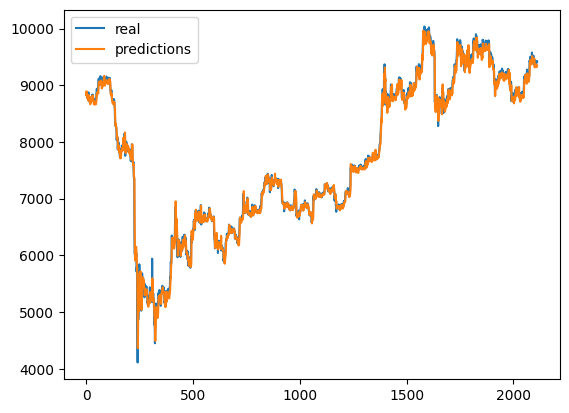

In [57]:
btc_df = plot_results(*MultiBTC(df = df_1h, scaler = StandardScaler()), printit=False)
make_model(btc_df)

# Zad 3